In [ ]:
# Install dependencies
!pip install ultralytics
!pip install albumentations
!pip install pytorch-lightning
!pip install tqdm

In [2]:
!wget https://motchallenge.net/data/MOT15.zip
!unzip -q MOT15.zip

--2025-04-29 11:29:15--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1.2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1.22G  14.1MB/s    in 96s     

2025-04-29 11:30:52 (13.0 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



In [3]:
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from ultralytics import YOLO

import glob
import os
from tqdm import tqdm
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from IPython.display import display

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Почему `YOLO`?
1. Легко дообучать
2. Внутри pytorch lightning
3. Есть logging и tensorboard
4. Может запускать в real-time при малых ресурсах
5. Мало весит
6. Легко Интегрируется с SORT-трекерами
7. Хорошее качество при детекции людей
  
Sources:  
[Object detection in real-time video surveillance using attention based transformer-YOLOv8 model](https://www.sciencedirect.com/science/article/pii/S1110016825000468#:~:text=YOLOv8%20is%20a%20real%2Dtime,class%20and%20real%2Dtime%20operation.)  
[SIMPLE ONLINE AND REALTIME TRACKING WITH A DEEP ASSOCIATION METRIC](https://arxiv.org/pdf/1703.07402)

In [4]:
DATASET_PATH = "/content/MOT15"
OUTPUT_DIR = "/content/output_checkpoints"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
SIZE_H = SIZE_W = 192 # 128

import albumentations as A

train_transform = A.Compose([
    A.Resize(SIZE_H, SIZE_W),

    # General distortions
    A.HorizontalFlip(p=0.2),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),

    # Light/Dark simulation
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),

    # Poor camera simulation
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.Downscale(scale_range=(0.5, 0.9), p=0.2),
    A.ImageCompression(quality_range=(30, 70), p=0.3),

    # Weather conditions
    A.RandomRain(p=0.2),
    A.RandomFog(fog_coef_range=(0.1, 0.3), p=0.2),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_limit=(1, 2), p=0.3),

    # Color shifts
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),

    # Noise simulation
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.3), p=0.2),
],
bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_visibility=0.3))

standart_transform = A.Compose([
      A.Resize(SIZE_H, SIZE_W),
  ])

Почему `Albumentations` для аугментации?   
1. Быстро работает на CPU
2. Очень разнообразные аугментации
3. Могут работать с bounding box'ами
4. Легко пользоваться
  
Source:  
[Albumentations: fast and flexible image
augmentations](https://arxiv.org/pdf/1809.06839)

In [6]:
def collect_images(dataset_path):
    images = glob.glob(os.path.join(dataset_path, "**", "img1", "*.jpg"), recursive=True)
    return images

In [7]:
train_image_paths = collect_images(DATASET_PATH / Path('train'))
print(f"Found {len(train_image_paths)} train images")

test_image_paths = collect_images(DATASET_PATH / Path('test'))
print(f"Found {len(test_image_paths)} test images")

Found 5500 train images
Found 5783 test images


In [8]:
def convert_mot_to_yolo(mot_dataset_root, output_labels_dir):

    os.makedirs(output_labels_dir, exist_ok=True)
    mode_path = Path(mot_dataset_root) / "train"

    for seq in os.listdir(mode_path):
        # Make label paths
        seq_path = mode_path / seq
        gt_path = seq_path / "gt/gt.txt"
        img_folder = seq_path / "img1"
        print(f"Processing sequence: {seq}")

        # Read
        with open(gt_path, "r") as f:
            lines = f.readlines()

        annotations_per_frame = {}
        min_width_pixels = 5
        min_height_pixels = 5

        for line in lines:
            fields = line.strip().split(',')

            frame = int(float(fields[0]))
            id_ = int(float(fields[1]))
            bb_left = float(fields[2])
            bb_top = float(fields[3])
            bb_width = float(fields[4])
            bb_height = float(fields[5])
            conf = float(fields[6])
            class_id = 0
            visibility = float(fields[8])

            # Skip ignored or bad bboxes
            if conf == 0 or id_ == -1 or bb_width < min_width_pixels or bb_height < min_height_pixels:
                continue

            # Read image size
            img_path = img_folder / f"{frame:06d}.jpg"
            img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

            img_h, img_w = img.shape[:2]

            # Normalize
            x_center = (bb_left + bb_width / 2) / img_w
            y_center = (bb_top + bb_height / 2) / img_h
            width = bb_width / img_w
            height = bb_height / img_h

            # Clamp values (safety)
            x_center = min(max(x_center, 0.0), 1.0)
            y_center = min(max(y_center, 0.0), 1.0)
            width = min(max(width, 0.0), 1.0)
            height = min(max(height, 0.0), 1.0)

            label_line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"

            if frame not in annotations_per_frame:
                annotations_per_frame[frame] = []

            annotations_per_frame[frame].append(label_line)

        for frame, labels in annotations_per_frame.items():
            label_filename = f"{seq}_{frame:06d}.txt"
            label_path = os.path.join(output_labels_dir, label_filename)
            with open(label_path, "w") as label_file:
                label_file.writelines(labels)

    print("\n✅ Done! All YOLO label files saved.")

In [9]:
# Example call
convert_mot_to_yolo(mot_dataset_root="/content/MOT15", output_labels_dir="/content/MOT15_labels")

Processing sequence: ETH-Sunnyday
Processing sequence: TUD-Stadtmitte
Processing sequence: KITTI-13
Processing sequence: ETH-Pedcross2
Processing sequence: ADL-Rundle-8
Processing sequence: PETS09-S2L1
Processing sequence: KITTI-17
Processing sequence: ETH-Bahnhof
Processing sequence: Venice-2
Processing sequence: TUD-Campus
Processing sequence: ADL-Rundle-6

✅ Done! All YOLO label files saved.


In [10]:
class MOTDataset(Dataset):
    def __init__(self, image_paths, label_root, transform=None):
        self.image_paths = image_paths
        self.label_root = label_root
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        parts = img_path.split('/')
        seq_name = parts[-3]
        frame_name = os.path.basename(img_path).split('.')[0]
        label_filename = f"{seq_name}_{frame_name}.txt"
        label_path = os.path.join(self.label_root, label_filename)

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        boxes.append([class_id, x_center, y_center, width, height])

        if not boxes:
            bboxes = []
            class_labels = []
        else:
            class_labels = [int(box[0]) for box in boxes]
            bboxes = [box[1:] for box in boxes]

        clamped_input_bboxes = []
        for bbox in bboxes:
            x_center, y_center, width, height = bbox

            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2

            x_min = max(0.0, min(1.0, x_min))
            y_min = max(0.0, min(1.0, y_min))
            x_max = max(0.0, min(1.0, x_max))
            y_max = max(0.0, min(1.0, y_max))

            if (x_max - x_min) < 0.01 or (y_max - y_min) < 0.01:
                continue

            new_x_center = (x_min + x_max) / 2
            new_y_center = (y_min + y_max) / 2
            new_width = x_max - x_min
            new_height = y_max - y_min

            clamped_input_bboxes.append([new_x_center, new_y_center, new_width, new_height])

        if self.transform:

            transformed = self.transform(
                image=image,
                bboxes=clamped_input_bboxes,
                class_labels=class_labels
            )
            image = transformed['image']
            bboxes = transformed['bboxes']
            class_labels = transformed['class_labels']

            new_clamped_bboxes = []
            new_class_labels = []

            for bbox, cls in zip(bboxes, class_labels):
                x_center, y_center, width, height = bbox

                x_min = max(0.0, min(1.0, x_center - width / 2))
                y_min = max(0.0, min(1.0, y_center - height / 2))
                x_max = max(0.0, min(1.0, x_center + width / 2))
                y_max = max(0.0, min(1.0, y_center + height / 2))

                if (x_max - x_min) < 0.01 or (y_max - y_min) < 0.01:
                    continue  # skip tiny/invalid boxes

                new_x_center = (x_min + x_max) / 2
                new_y_center = (y_min + y_max) / 2
                new_width = x_max - x_min
                new_height = y_max - y_min

                new_clamped_bboxes.append([new_x_center, new_y_center, new_width, new_height])
                new_class_labels.append(cls)

            bboxes = new_clamped_bboxes
            class_labels = new_class_labels

        boxes = [[cls] + list(bbox) for cls, bbox in zip(class_labels, bboxes)]
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        return image, boxes

In [11]:
train_image_paths = collect_images("/content/MOT15" / Path('train'))
label_root = "/content/MOT15_labels"

train_img_paths, val_img_paths = train_test_split(
    train_image_paths,
    test_size=0.2,
    shuffle=True
)

train_dataset = MOTDataset(image_paths=train_img_paths, label_root=label_root, transform=train_transform)
val_dataset = MOTDataset(image_paths=val_img_paths, label_root=label_root, transform=standart_transform)

#### Проверим аугментированный трейновый датасет

In [12]:
def visualize_sample_with_boxes(dataset, idx):
    img, boxes = dataset[idx]

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).clip(0, 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)

    img_w, img_h = img_pil.size

    for box in boxes:

        class_id, x_center, y_center, width, height = box

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        x_min = max(0.0, min(1.0, x_min))
        y_min = max(0.0, min(1.0, y_min))
        x_max = max(0.0, min(1.0, x_max))
        y_max = max(0.0, min(1.0, y_max))

        if x_max <= x_min or y_max <= y_min:
            continue

        x1 = x_min * img_w
        y1 = y_min * img_h
        x2 = x_max * img_w
        y2 = y_max * img_h

        if (x2 - x1) < 1 or (y2 - y1) < 1:
            continue

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"ID:{int(class_id)}", fill="red")

    return img_pil


def visualize_grid(dataset, num_images=8, rows=2, cols=4):
    import random
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

    for i in range(num_images):
        smpl = random.randint(0, len(dataset) - 1)
        img_pil = visualize_sample_with_boxes(dataset, idx=smpl)

        ax = axes[i // cols, i % cols]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f"Sample {smpl}")

    plt.tight_layout()
    plt.show()



def visualize_grid(dataset, num_images=8, rows=2, cols=4):
    import random
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

    for i in range(num_images):
        smpl = random.randint(0, len(dataset) - 1)
        img_pil = visualize_sample_with_boxes(dataset, idx=smpl)

        ax = axes[i // cols, i % cols]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f"Sample {smpl}")

    plt.tight_layout()
    plt.show()

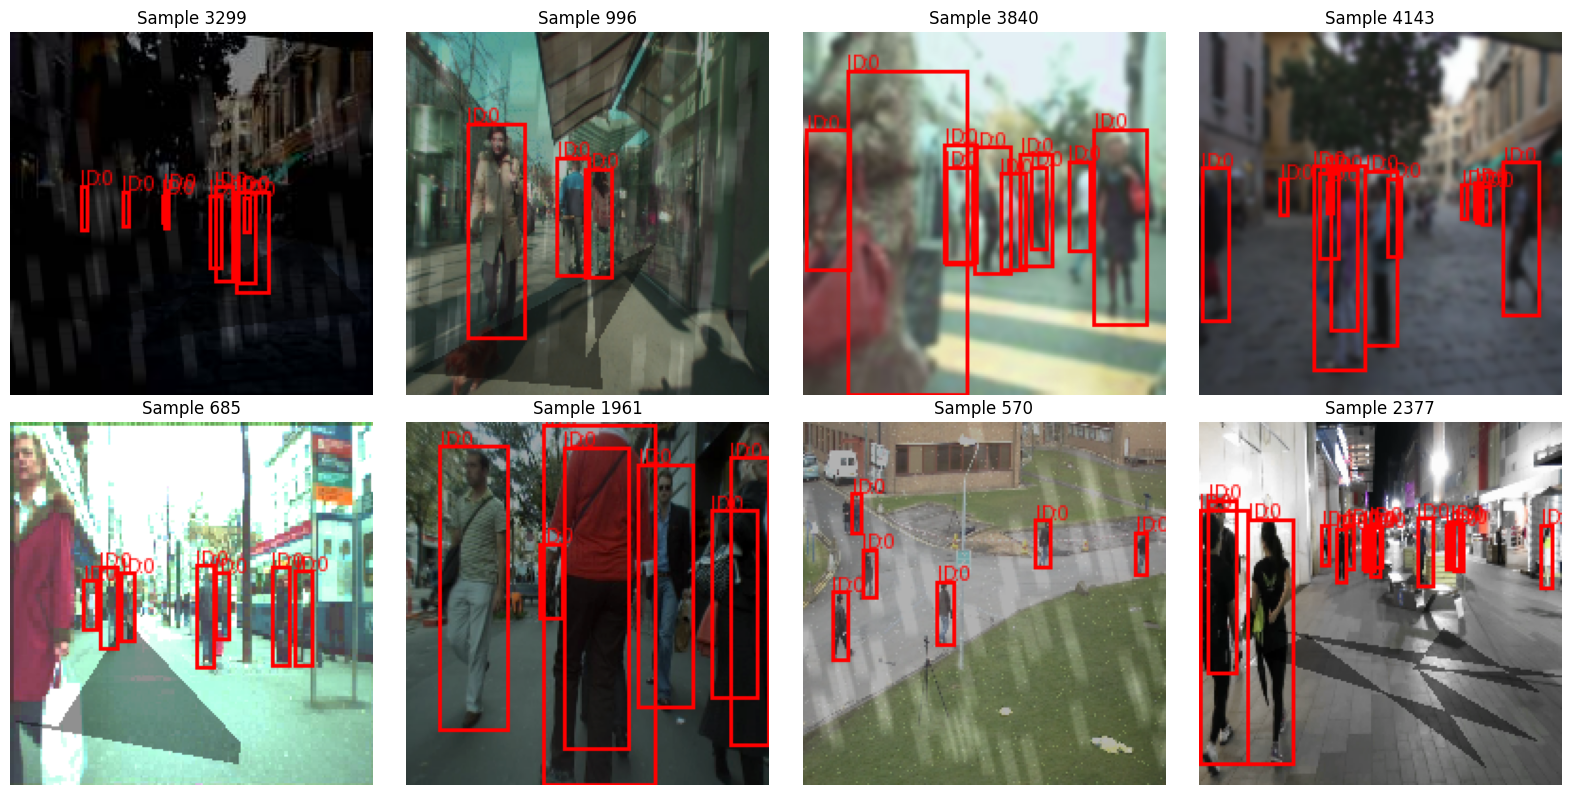

In [13]:
visualize_grid(train_dataset, num_images=8, rows=2, cols=4)

#### Проверим валидационный датасет

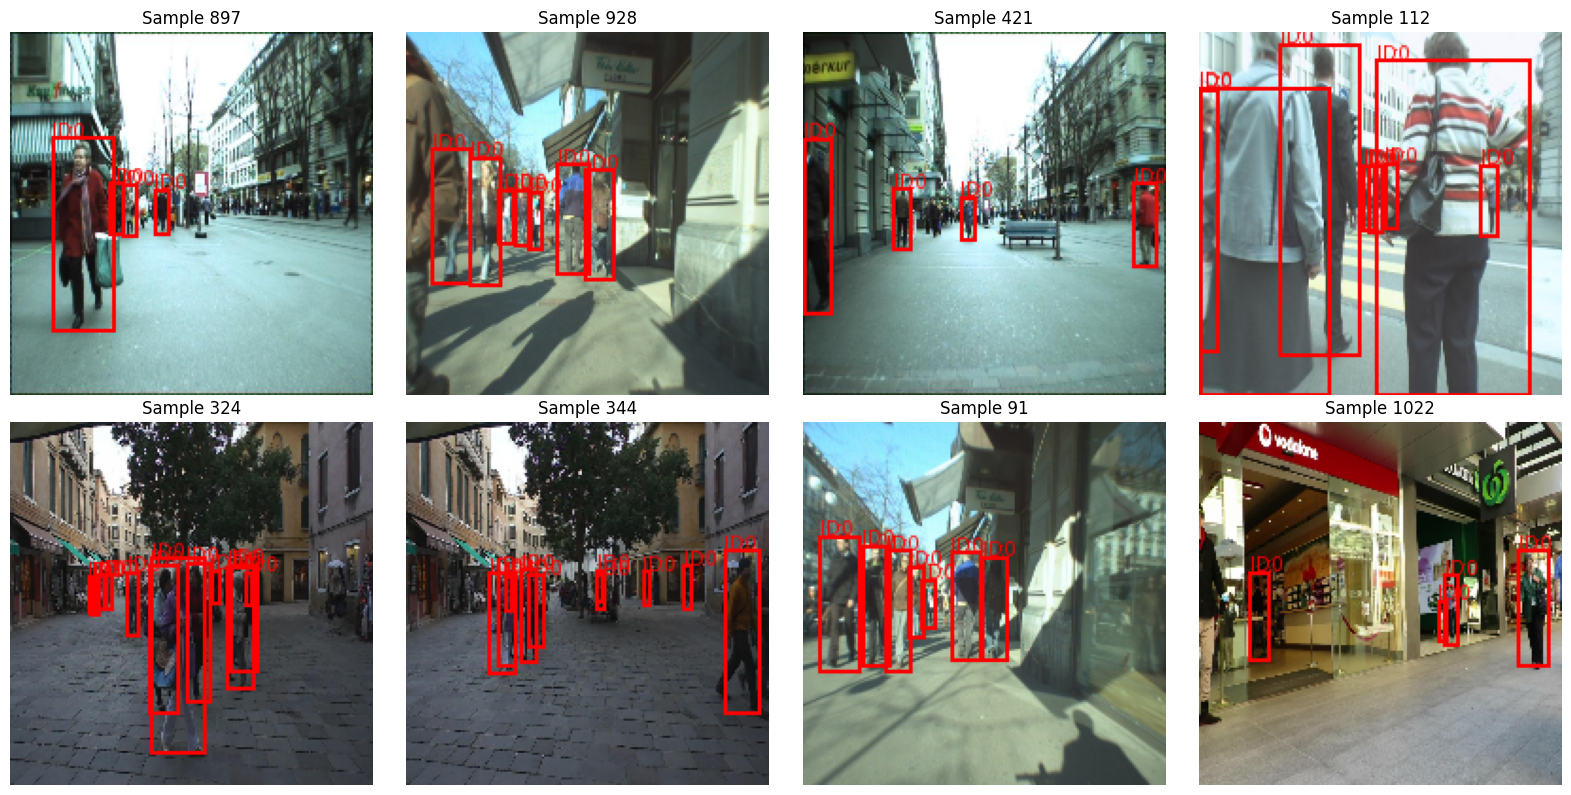

In [14]:
visualize_grid(val_dataset, num_images=8, rows=2, cols=4)

#### Тестовый датасет & DataLoaders

In [15]:
image_paths = collect_images("/content/MOT15" / Path('test'))
label_root = ""

test_dataset = MOTDataset(image_paths=image_paths, label_root=label_root, transform=standart_transform)

In [16]:
def mot_collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    return images, targets

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=mot_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=mot_collate_fn)

In [17]:
for images, labels in train_loader:
    print(f"Train batch images shape: {images.shape}")
    print(f"Train batch labels shape: {len(labels)}")
    break

for images, labels in val_loader:
    print(f"Val batch images shape: {images.shape}")
    print(f"Val batch labels shape: {len(labels)}")
    break


Train batch images shape: torch.Size([8, 3, 192, 192])
Train batch labels shape: 8
Val batch images shape: torch.Size([8, 3, 192, 192])
Val batch labels shape: 8


#### Data to `.yaml`

In [19]:
def save_dataset(dataset, save_images_dir: Path, save_labels_dir: Path):

    os.makedirs(save_images_dir, exist_ok=True)
    os.makedirs(save_labels_dir, exist_ok=True)

    for idx in tqdm(range(len(dataset))):

        try:
          image, labels = dataset[idx]

          img = image.permute(1, 2, 0).cpu().numpy() * 255
          img = img.clip(0, 255).astype('uint8')
          img_pil = Image.fromarray(img)
          img_pil.save(save_images_dir / f'{idx:06}.jpg')

          with open(save_labels_dir / f'{idx:06}.txt', 'w') as f:
              for label in labels:
                  cls, x_center, y_center, width, height = label
                  f.write(f"{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
        except ValueError:
          continue


save_dataset(train_dataset, Path('/content/MOT15/images/train'), Path('/content/MOT15/labels/train'))
save_dataset(val_dataset, Path('/content/MOT15/images/val'), Path('/content/MOT15/labels/val'))

100%|██████████| 1100/1100 [00:11<00:00, 99.47it/s] 


#### Модель

In [20]:
yaml_content = """
    path: /content/MOT15
    train: images/train
    val: images/val
    nc: 1
    names: ['person']
    """

with open('mot15.yaml', 'w') as f:
    f.write(yaml_content)

In [21]:
model = YOLO("yolo11n.pt")
results = model.train(data="mot15.yaml",
                      epochs=100,
                      imgsz=192,
                      batch=8,
                      patience=10,
                      optimizer='Adam')

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.6MB/s]


Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=mot15.yaml, epochs=100, time=None, patience=10, batch=8, imgsz=192, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torc

100%|██████████| 755k/755k [00:00<00:00, 20.5MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 402.2±177.3 MB/s, size: 8.0 KB)


train: Scanning /content/MOT15/labels/train... 4399 images, 76 backgrounds, 0 corrupt: 100%|██████████| 4399/4399 [00:01<00:00, 2365.98it/s]

train: /content/MOT15/images/train/002795.jpg: 1 duplicate labels removed
train: /content/MOT15/images/train/003304.jpg: 1 duplicate labels removed
train: New cache created: /content/MOT15/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 301.0±169.0 MB/s, size: 9.5 KB)


val: Scanning /content/MOT15/labels/val... 1100 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<00:00, 2091.09it/s]

val: New cache created: /content/MOT15/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 192 train, 192 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.254G      2.348       1.64      1.392         73        192: 100%|██████████| 550/550 [01:05<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.43it/s]


                   all       1100       8104      0.464      0.395      0.374      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.281G      2.295      1.553      1.377         66        192: 100%|██████████| 550/550 [00:57<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.87it/s]


                   all       1100       8104      0.587      0.458      0.461      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.293G      2.197      1.475       1.33         39        192: 100%|██████████| 550/550 [00:55<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.71it/s]


                   all       1100       8104      0.652      0.466      0.521      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.305G      2.152      1.432      1.308         68        192: 100%|██████████| 550/550 [00:55<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.29it/s]


                   all       1100       8104      0.691      0.473       0.55      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      0.32G      2.091      1.361      1.276         84        192: 100%|██████████| 550/550 [00:57<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  8.72it/s]


                   all       1100       8104      0.709      0.516      0.591      0.276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.336G      2.055      1.335      1.258         58        192: 100%|██████████| 550/550 [01:02<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  8.85it/s]

                   all       1100       8104      0.689      0.494       0.57      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      0.35G      2.014       1.31      1.246         78        192: 100%|██████████| 550/550 [01:01<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.39it/s]

                   all       1100       8104       0.74      0.524      0.618      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.363G      1.986      1.281      1.232         50        192: 100%|██████████| 550/550 [01:00<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.86it/s]


                   all       1100       8104      0.722      0.505       0.59      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.379G      1.977      1.265      1.232         55        192: 100%|██████████| 550/550 [00:57<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.16it/s]

                   all       1100       8104      0.762      0.521      0.623      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.393G      1.978      1.259      1.226         83        192: 100%|██████████| 550/550 [00:58<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.76it/s]

                   all       1100       8104      0.719      0.533      0.605      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.408G      1.956      1.257       1.21         73        192: 100%|██████████| 550/550 [00:56<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.78it/s]


                   all       1100       8104       0.75      0.539      0.644      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.422G      1.955      1.251      1.207         86        192: 100%|██████████| 550/550 [00:56<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.78it/s]

                   all       1100       8104      0.745      0.518      0.631      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.438G      1.941      1.235      1.201         56        192: 100%|██████████| 550/550 [00:56<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00,  9.94it/s]


                   all       1100       8104      0.757      0.529      0.633      0.324

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.453G      1.926      1.211      1.194        101        192: 100%|██████████| 550/550 [00:57<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.96it/s]


                   all       1100       8104      0.753      0.533      0.638      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.467G      1.916      1.198      1.187         66        192: 100%|██████████| 550/550 [00:58<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.92it/s]


                   all       1100       8104      0.753      0.548      0.647      0.325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      0.48G      1.906      1.212       1.19         60        192: 100%|██████████| 550/550 [00:57<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.28it/s]


                   all       1100       8104       0.78       0.54      0.658      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.496G      1.895       1.19       1.18         60        192: 100%|██████████| 550/550 [00:57<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.78it/s]

                   all       1100       8104      0.762      0.544      0.642      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.512G      1.891      1.192      1.183         49        192: 100%|██████████| 550/550 [00:56<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]

                   all       1100       8104      0.755      0.565      0.667      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.525G      1.877      1.164      1.169         59        192: 100%|██████████| 550/550 [00:56<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.76it/s]


                   all       1100       8104      0.773      0.547      0.668      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.541G       1.87      1.166      1.172         57        192: 100%|██████████| 550/550 [00:57<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.98it/s]


                   all       1100       8104      0.782      0.571       0.68      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.557G      1.873      1.164      1.168        122        192: 100%|██████████| 550/550 [00:57<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.89it/s]

                   all       1100       8104      0.786       0.57      0.683      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      0.57G      1.863      1.172      1.175         90        192: 100%|██████████| 550/550 [00:57<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.90it/s]


                   all       1100       8104      0.755      0.569      0.678      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.586G      1.856      1.155      1.161         86        192: 100%|██████████| 550/550 [00:57<00:00,  9.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.59it/s]

                   all       1100       8104      0.797      0.568       0.68      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       0.6G      1.837      1.142      1.158         64        192: 100%|██████████| 550/550 [00:56<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.16it/s]

                   all       1100       8104      0.762      0.564      0.681      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.613G      1.843      1.143      1.158         64        192: 100%|██████████| 550/550 [00:57<00:00,  9.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.77it/s]


                   all       1100       8104      0.786      0.575      0.689      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.627G      1.843      1.144      1.165         81        192: 100%|██████████| 550/550 [00:57<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.70it/s]

                   all       1100       8104      0.762      0.573       0.69      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.643G      1.833      1.136      1.161         95        192: 100%|██████████| 550/550 [00:57<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.96it/s]


                   all       1100       8104      0.766      0.587      0.695      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.658G      1.837      1.139      1.152         91        192: 100%|██████████| 550/550 [00:58<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.13it/s]


                   all       1100       8104      0.785      0.588      0.693      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.674G      1.834      1.131      1.152         64        192: 100%|██████████| 550/550 [00:57<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]

                   all       1100       8104      0.779      0.582      0.695      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.686G      1.828      1.125      1.156         78        192: 100%|██████████| 550/550 [00:57<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.63it/s]


                   all       1100       8104      0.783      0.576      0.692      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.701G      1.813      1.118      1.146         74        192: 100%|██████████| 550/550 [00:57<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.33it/s]

                   all       1100       8104      0.773      0.586      0.696      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.717G      1.804      1.117      1.142         14        192: 100%|██████████| 550/550 [00:57<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.98it/s]

                   all       1100       8104      0.758      0.572      0.679       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.732G      1.788      1.097      1.138         88        192: 100%|██████████| 550/550 [00:57<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.94it/s]

                   all       1100       8104      0.797      0.603      0.714      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.746G      1.799      1.098      1.137         77        192: 100%|██████████| 550/550 [00:57<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.11it/s]


                   all       1100       8104       0.79      0.595      0.708      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      0.76G      1.798      1.102      1.137         85        192: 100%|██████████| 550/550 [00:56<00:00,  9.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00,  9.87it/s]


                   all       1100       8104      0.787      0.591      0.708       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.775G      1.791      1.095      1.133         88        192: 100%|██████████| 550/550 [00:56<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00,  9.87it/s]


                   all       1100       8104      0.783       0.59      0.702       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.791G      1.792      1.096      1.138         55        192: 100%|██████████| 550/550 [00:56<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.70it/s]

                   all       1100       8104      0.802      0.582      0.707      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.805G      1.785      1.083      1.134         68        192: 100%|██████████| 550/550 [00:57<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.77it/s]


                   all       1100       8104      0.792      0.617      0.724      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.818G      1.765      1.084      1.128         63        192: 100%|██████████| 550/550 [00:57<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.98it/s]


                   all       1100       8104      0.801      0.605      0.715      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.834G       1.78      1.079       1.13         45        192: 100%|██████████| 550/550 [00:57<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 11.01it/s]


                   all       1100       8104      0.793      0.619      0.719      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.848G      1.774      1.078      1.127         53        192: 100%|██████████| 550/550 [00:59<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  8.88it/s]


                   all       1100       8104      0.796      0.616      0.721      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.863G       1.76      1.069      1.119         88        192: 100%|██████████| 550/550 [01:01<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 11.04it/s]


                   all       1100       8104      0.802      0.604      0.716      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.879G       1.76      1.071      1.125         83        192: 100%|██████████| 550/550 [00:57<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.96it/s]


                   all       1100       8104      0.778      0.618      0.717      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.893G       1.76      1.066      1.125         51        192: 100%|██████████| 550/550 [00:57<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.76it/s]

                   all       1100       8104      0.815      0.602      0.724      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.908G      1.751      1.049      1.115         83        192: 100%|██████████| 550/550 [00:56<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00,  9.86it/s]

                   all       1100       8104      0.795       0.62      0.728      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.924G      1.753       1.06      1.116         64        192: 100%|██████████| 550/550 [00:56<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


                   all       1100       8104      0.818      0.622      0.734      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.938G      1.743      1.051      1.111        110        192: 100%|██████████| 550/550 [00:56<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00,  9.96it/s]


                   all       1100       8104      0.785      0.618      0.721      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.953G      1.733      1.039      1.111         56        192: 100%|██████████| 550/550 [00:55<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.49it/s]

                   all       1100       8104      0.785      0.632      0.735      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.967G       1.73       1.05      1.122         78        192: 100%|██████████| 550/550 [00:56<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 11.05it/s]


                   all       1100       8104      0.805      0.617      0.732      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.982G       1.73      1.036      1.109         53        192: 100%|██████████| 550/550 [00:56<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 11.07it/s]


                   all       1100       8104      0.815      0.629      0.738      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.996G      1.735      1.043      1.108         99        192: 100%|██████████| 550/550 [00:57<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.60it/s]

                   all       1100       8104      0.809      0.635      0.743      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.01G      1.725       1.04      1.112         55        192: 100%|██████████| 550/550 [00:56<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]

                   all       1100       8104      0.811      0.622      0.735      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.03G       1.72      1.031      1.111         67        192: 100%|██████████| 550/550 [00:56<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.72it/s]

                   all       1100       8104      0.813      0.634      0.743      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.04G      1.727      1.033      1.106         64        192: 100%|██████████| 550/550 [00:56<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.45it/s]


                   all       1100       8104      0.809      0.634      0.744      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.05G      1.705      1.024      1.102         84        192: 100%|██████████| 550/550 [00:55<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.29it/s]


                   all       1100       8104      0.824      0.631      0.745      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.07G      1.714      1.023        1.1         96        192: 100%|██████████| 550/550 [00:55<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.77it/s]

                   all       1100       8104      0.813      0.633      0.745      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.08G      1.706      1.023      1.103         93        192: 100%|██████████| 550/550 [00:56<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.39it/s]

                   all       1100       8104      0.808      0.642      0.748      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       1.1G       1.71      1.023      1.105         99        192: 100%|██████████| 550/550 [00:57<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 11.07it/s]


                   all       1100       8104      0.808       0.64      0.745      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.12G      1.701      1.021        1.1         83        192: 100%|██████████| 550/550 [00:56<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:06<00:00, 10.17it/s]

                   all       1100       8104      0.811      0.635      0.749      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.13G      1.685      1.008      1.099         68        192: 100%|██████████| 550/550 [00:55<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.66it/s]


                   all       1100       8104      0.811      0.638      0.749      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.14G      1.685      1.008      1.099         49        192: 100%|██████████| 550/550 [00:55<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.82it/s]


                   all       1100       8104      0.804      0.649      0.747      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.16G      1.687     0.9974       1.09         89        192: 100%|██████████| 550/550 [00:55<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.82it/s]

                   all       1100       8104      0.811       0.65      0.752      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.17G      1.689     0.9974      1.097         61        192: 100%|██████████| 550/550 [00:55<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.54it/s]


                   all       1100       8104      0.815      0.637      0.752      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.19G      1.681     0.9984      1.094        122        192: 100%|██████████| 550/550 [00:54<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:07<00:00,  9.68it/s]


                   all       1100       8104      0.819      0.651      0.757      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       1.2G      1.672     0.9609      1.063         86        192:   4%|▍         | 21/550 [00:02<00:53,  9.92it/s]


KeyboardInterrupt: 

#### Metrics:
* box_loss - Bounding box regression loss (lower = bounding boxes are getting more accurate)
* cls_loss - Classification loss (lower = class predictions getting more accurate)
* dfl_loss - Distribution Focal Loss (lower = better object localization precision)
* mAP50 - How well your model predicts (higher = model getting better at detecting objects)
* mAP50-95 - mean Average Precision averaged across IoU thresholds (hihger = model generalizing across harder overlaps)
* Box(P) - Precision
* R - Recall

In [23]:
best_model = YOLO("yolo11n.pt")

metrics = best_model.val(data="mot15.yaml", imgsz=192)
print(metrics)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 410.8±130.9 MB/s, size: 8.7 KB)


val: Scanning /content/MOT15/labels/val.cache... 1100 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:08<00:00,  8.37it/s]


                   all       1100       8104      0.709      0.451      0.527      0.242
                person       1080       8104      0.709      0.451      0.527      0.242
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79dac07cb410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,

In [22]:
best_model = YOLO("/content/runs/detect/train/weights/best.pt")

metrics = best_model.val(data="mot15.yaml", imgsz=192)
print(metrics)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 352.0±110.5 MB/s, size: 8.4 KB)


val: Scanning /content/MOT15/labels/val.cache... 1100 images, 20 backgrounds, 0 corrupt: 100%|██████████| 1100/1100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 69/69 [00:12<00:00,  5.54it/s]


                   all       1100       8104      0.821      0.651      0.758      0.434
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79db3ebbac10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033